Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Provide full answers for each question, including interpretation of the results. Each question is worth 25 points.

This homework is due on Monday, November 30, 2015.

## Question 1

The `titanic.xls` spreadsheet in the `data` directory contains data regarding the passengers on the Titanic when it sank in 1912. A recent [Kaggle competition](http://www.kaggle.com/c/titanic-gettingStarted) was based on predicting survival for passengers based on the attributes in the passenger list. 

Use scikit-learn to build both a support vector classifier and a logistic regression model to predict survival on the Titanic. Use cross-validation to assess your models, and try to tune them to improve performance.

Discuss the benefits and drawbacks of both approaches for application to such problems.

In [53]:
# Write your work here

## Question 2

The data in `prostate.data.txt` come from a study by Stamey et al. (1989), which examined the correlation between the level of prostate-specific antigen (`lpsa`) and a number of clinical measures in men who were about to receive a radical prostatectomy. The variables are log cancer volume (`lcavol`), log prostate weight (`lweight`), age, log of the amount of benign prostatic hyperplasia (`lbph`), seminal vesicle invasion (`svi`), log of capsular penetration (`lcp`), Gleason score (`gleason`), and percent of Gleason scores 4 or 5 (`pgg45`). 

1. Select (your choice) five competing 3-variable linear regression models, and compare them using AIC, five-fold and ten-fold cross-validation. Discuss the results.

2. An alternative method for model assessment is to fit the models on a set of bootstrap samples, and then keep track of how well it predicts the original training set. If $\hat{f}^b(x_i)$ is the predicted value at $x_i$, from the model fitted to the bth bootstrap dataset, such an estimate is:
$$\frac{1}{B} \frac{1}{N} \sum_{b=1}^B \sum_{i=1}^N L(y_i,\hat{f}^b(x_i)) $$
However, because the bootstrap samples tend to contain many observations in common among the set of bootstrap samples, this estimate will tend to underestimate the true error rate. The so-called .632 estimator aleviates this bias by returning a weighted average of the training error (average loss over the training sample) and the leave-one-out (LOO) bootstrap error:
$$\hat{err}^{(.632)} = 0.368 \, \bar{err} + 0.632 \, \hat{err}^{(1)}$$
where:
$$\bar{err} = \frac{1}{N}\sum_{i=1}^N L(y_i, \hat{f}(x_i)) $$
Repeat the assesment from part (1) using the .632 estimator, and compare the result to the other approaches.

In [54]:
# Load the data
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
mat = pd.read_csv('../data/prostate.data.txt',sep='\t')
X = mat.copy()
variables = ['lcavol','lweight','lbph','svi','lcp','gleason','pgg45']
y = X.pop('lpsa')
X = {x:X.pop(x) for x in variables}
X = pd.DataFrame(X)

In [55]:
# Lets look at AIC
aic = lambda g: g.nobs * np.log((g.resid**2).sum()/g.nobs) + 2*len(g.beta)

models = [
    [1,1,0,1,0,0,0],
    [1,0,1,0,0,0,1],
    [0,1,0,0,1,1,0],
    [0,0,0,0,1,1,1],
    [0,1,0,1,0,1,0],
]
models = np.array(models)>0
aics = []
for i in range(models.shape[0]):
    X_pred = X[X.columns[models[i,:]]]
    g = pd.ols(y=y, x=X_pred)
    aics.append(aic(g))
print(aics)

[-5.7532595927925083, -49.663553057345638, -4.2014833010948749, -27.013032512161338, -5.6269934066868146]


This shows that the second model is the best

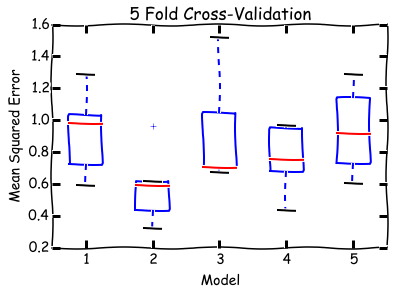

In [56]:
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import metrics
# Switching to scikit-learn since that's more comfortable for me

X = np.array(X)
y = np.array(y)

n_folds = 5
kfold = cross_validation.KFold(X.shape[0],n_folds=n_folds,shuffle=True)
scores = np.zeros([n_folds,models.shape[0]])
n = 0
for train,test in kfold:
    for i in range(models.shape[0]):
        X_train = X[train,:]
        X_train = X_train[:,models[i,:]]
        X_test = X[test,:]
        X_test = X_test[:,models[i,:]]
        y_train = y[train]
        y_test = y[test]
        model = linear_model.LinearRegression()
        model.fit(X_train,y_train)
        y_hat = model.predict(X_test)
        scores[n,i] = metrics.mean_squared_error(y_hat,y_test)
    n += 1
plt.xkcd()
plt.boxplot(scores)
plt.ylabel('Mean Squared Error')
plt.xlabel('Model')
plt.title('5 Fold Cross-Validation')

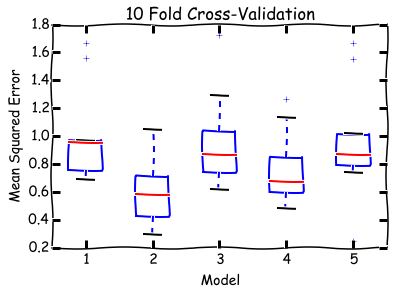

In [57]:
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import metrics
# Switching to scikit-learn since that's more comfortable for me

X = np.array(X)
y = np.array(y)

n_folds = 10
kfold = cross_validation.KFold(X.shape[0],n_folds=n_folds,shuffle=True)
scores = np.zeros([n_folds,models.shape[0]])
n = 0
for train,test in kfold:
    for i in range(models.shape[0]):
        X_train = X[train,:]
        X_train = X_train[:,models[i,:]]
        X_test = X[test,:]
        X_test = X_test[:,models[i,:]]
        y_train = y[train]
        y_test = y[test]
        model = linear_model.LinearRegression()
        model.fit(X_train,y_train)
        y_hat = model.predict(X_test)
        scores[n,i] = metrics.mean_squared_error(y_hat,y_test)
    n += 1
plt.xkcd()
plt.boxplot(scores)
plt.ylabel('Mean Squared Error')
plt.xlabel('Model')
plt.title('10 Fold Cross-Validation')

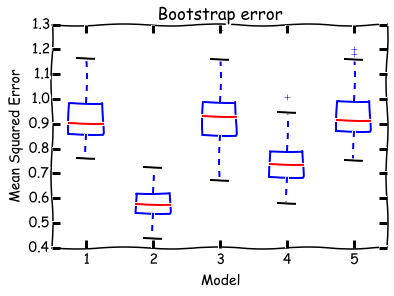

In [58]:
def build_bootstrap_sample(n,rng_state=None):
    held_out = np.ones(n,dtype=bool)
    np.random.RandomState(rng_state)
    samples = []
    for _ in range(n):
        k = np.random.randint(n)
        samples.append(k)
        held_out[k] = False
    samples = np.array(samples)
    return samples,held_out
    
n_folds = 100
scores = np.zeros([n_folds,models.shape[0]])
for i in range(n_folds):
    samples,held_out = build_bootstrap_sample(X.shape[0])
    y_train = y[samples]
    y_test = y[held_out]
    for j in range(models.shape[0]):
        X_train = X[samples,:]
        X_test = X[held_out,:]
        X_train = X_train[:,models[j,:]]
        X_test = X_test[:,models[j,:]]
        model = linear_model.LinearRegression()
        model.fit(X_train,y_train)
        y_train_hat = model.predict(X_train)
        y_test_hat = model.predict(X_test)
        err_bar = metrics.mean_squared_error(y_train,y_train_hat)
        err_boot = metrics.mean_squared_error(y_test_hat,y_test)
        err = 0.368*err_bar + 0.632*err_boot
        scores[i,j] = err
plt.xkcd()        
plt.boxplot(scores)
plt.ylabel('Mean Squared Error')
plt.xlabel('Model')
plt.title('Bootstrap error')

## Question 3

Fit a series of random-forest classifiers to the very low birthweight infant data (`vlbw.csv`), to explore the sensitivity to the parameter `m`, the number of variables considered for splitting at each step. Plot both the out-of-bag error as well as the test error against a suitably-chosen range of values for `m`.

In [59]:
# Write your work here

## Bonus: Question 4

Use a grid search to optimize the number of estimators and max_depth for a Gradient Boosted Decision tree using the very low birthweight infant data. Plug this optimal ``max_depth`` into a *single* decision tree.  Does this single tree over-fit or under-fit the data? Repeat this for the Random Forest.  Construct a single decision tree using the ``max_depth`` which is optimal for the Random Forest.  Does this single tree over-fit or under-fit the data?

In [60]:
# Write your work here